Problem: Netflix is interested in acquiring some of the top movies of all time. What factors lead to their popularity? Rating = target variable.

In [478]:
# Imports at the top
import json
from urllib import urlopen
import pandas as pd
import numpy as np
import requests
import json
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFECV
from sklearn import metrics

In [217]:
# get IMDB's top 250
titles = pd.read_html('http://www.imdb.com/chart/top')
titles = titles[0]['Rank & Title']

In [218]:
titles.head()

0    1.  The Shawshank Redemption  (1994)
1               2.  The Godfather  (1972)
2      3.  The Godfather: Part II  (1974)
3             4.  The Dark Knight  (2008)
4                5.  12 Angry Men  (1957)
Name: Rank & Title, dtype: object

In [220]:
# clean them and replace spaces with + so they're ready for API
clean_titles = []
for x in titles:
    title = " ".join(re.findall("[a-zA-Z]+", x)).replace(' ','+')
    clean_titles.append(title)

In [221]:
# these are the top 250 titles
clean_titles

[u'The+Shawshank+Redemption',
 u'The+Godfather',
 u'The+Godfather+Part+II',
 u'The+Dark+Knight',
 u'Angry+Men',
 u'Schindler+s+List',
 u'Pulp+Fiction',
 u'The+Lord+of+the+Rings+The+Return+of+the+King',
 u'The+Good+the+Bad+and+the+Ugly',
 u'Fight+Club',
 u'The+Lord+of+the+Rings+The+Fellowship+of+the+Ring',
 u'Star+Wars+Episode+V+The+Empire+Strikes+Back',
 u'Forrest+Gump',
 u'Inception',
 u'The+Lord+of+the+Rings+The+Two+Towers',
 u'One+Flew+Over+the+Cuckoo+s+Nest',
 u'Goodfellas',
 u'The+Matrix',
 u'Seven+Samurai',
 u'Star+Wars+Episode+IV+A+New+Hope',
 u'La+La+Land',
 u'City+of+God',
 u'Se+en',
 u'The+Silence+of+the+Lambs',
 u'It+s+a+Wonderful+Life',
 u'The+Usual+Suspects',
 u'Life+Is+Beautiful',
 u'L+on+The+Professional',
 u'Spirited+Away',
 u'Saving+Private+Ryan',
 u'Once+Upon+a+Time+in+the+West',
 u'American+History+X',
 u'Interstellar',
 u'Casablanca',
 u'Psycho',
 u'City+Lights',
 u'The+Green+Mile',
 u'Raiders+of+the+Lost+Ark',
 u'The+Intouchables',
 u'Modern+Times',
 u'Rear+Window'

In [210]:
# get top 500 titles from Empire magazine to add more data
url = 'http://www.empireonline.com/movies/features/500-greatest-movies/'
soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
results = soup.find_all('h2')   

In [213]:
empire_titles = []
for r in results:
    title = r.text.strip()
    empire_titles.append(title)

In [224]:
# clean and add +'s
emp_titles = []
for x in empire_titles:
    title = " ".join(re.findall("[a-zA-Z]+", x)).replace(' ','+')
    emp_titles.append(title)

In [226]:
emp_titles[0]

u'Ocean+s+Eleven'

In [233]:
# merge the two
titles = clean_titles + emp_titles

In [242]:
# use merged list to query omdb api
data = []
for title in titles:
    resp = requests.get('http://www.omdbapi.com/?t={}&tomatoes=true'.format(title))
    j = json.loads(resp.text)
    data.append(j)

In [243]:
movies = pd.DataFrame(data)

In [245]:
del movies['Error']
del movies['tomatoURL']
del movies['totalSeasons']

In [249]:
del movies['tomatoImage']

In [247]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 34 columns):
Actors               685 non-null object
Awards               685 non-null object
BoxOffice            685 non-null object
Country              685 non-null object
DVD                  685 non-null object
Director             685 non-null object
Genre                685 non-null object
Language             685 non-null object
Metascore            685 non-null object
Plot                 685 non-null object
Poster               685 non-null object
Production           685 non-null object
Rated                685 non-null object
Released             685 non-null object
Response             752 non-null object
Runtime              685 non-null object
Title                685 non-null object
Type                 685 non-null object
Website              685 non-null object
Writer               685 non-null object
Year                 685 non-null object
imdbID               685 non-null 

In [248]:
movies.head()

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoConsensus,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 19 wins & 30 n...,N/A,USA,27 Jan 1998,Frank Darabont,"Crime, Drama",English,80,Two imprisoned men bond over a number of years...,...,"The Shawshank Redemption is an uplifting, deep...",61,certified,91,8.2,67,6,98,4.4,881901
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",Won 3 Oscars. Another 23 wins & 27 nominations.,N/A,USA,09 Oct 2001,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100,The aging patriarch of an organized crime dyna...,...,One of Hollywood's greatest critical and comme...,83,certified,99,9.2,84,1,98,4.4,728802
2,"David Chase, Mick LaSalle, Richard Marks, Kenn...",N/A,N/A,USA,N/A,N/A,"Documentary, Short",English,N/A,A short that features various interviewees dis...,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Won 2 Oscars. Another 146 wins & 142 nominations.,"$533,316,061.00","USA, UK",09 Dec 2008,Christopher Nolan,"Action, Crime, Drama","English, Mandarin",82,When the menace known as the Joker wreaks havo...,...,"Dark, complex and unforgettable, The Dark Knig...",298,certified,94,8.6,317,19,94,4.4,1824965
4,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",Nominated for 3 Oscars. Another 16 wins & 8 no...,N/A,USA,06 Mar 2001,Sidney Lumet,"Crime, Drama",English,N/A,A jury holdout attempts to prevent a miscarria...,...,Sidney Lumet's feature debut is a superbly wri...,48,certified,100,8.9,48,0,97,4.2,103072


In [253]:
mov = movies.replace('N/A',np.nan)

In [254]:
mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 33 columns):
Actors               680 non-null object
Awards               642 non-null object
BoxOffice            169 non-null object
Country              685 non-null object
DVD                  638 non-null object
Director             673 non-null object
Genre                684 non-null object
Language             682 non-null object
Metascore            418 non-null object
Plot                 678 non-null object
Poster               669 non-null object
Production           636 non-null object
Rated                650 non-null object
Released             677 non-null object
Response             752 non-null object
Runtime              683 non-null object
Title                685 non-null object
Type                 685 non-null object
Website              287 non-null object
Writer               668 non-null object
Year                 685 non-null object
imdbID               685 non-null 

In [262]:
mov = mov.dropna(axis = 0, subset = ['Title'])

In [269]:
mov = mov.drop_duplicates(subset = ['Title'])

In [272]:
mov = mov.dropna(axis = 0, subset = ['imdbRating'])

In [281]:
mov['imdbRating'] = mov['imdbRating'].astype('float')

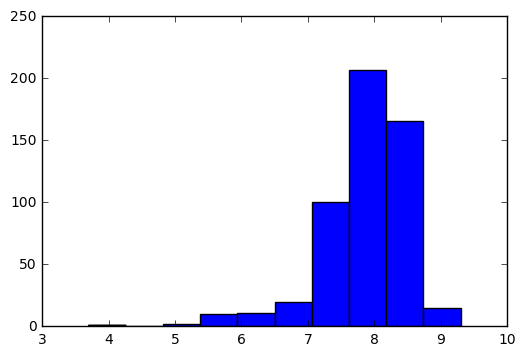

In [282]:
# plot 
plt.hist(mov['imdbRating'])
plt.show()

In [283]:
# get top 1000 titles from NYT to add more data
url = 'http://www.nytimes.com/ref/movies/1000best.html'
soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
results = soup.find_all('a href')   

In [337]:
results = soup.find_all('a', href = re.compile('^http://movies.nytimes.com/movie'))

In [346]:
nyt_titles = []
for i in results:
    title = i.text.strip()
    nyt_titles.append(title)
    

In [348]:
# clean and add +'s
titles = []
for x in nyt_titles:
    title = " ".join(re.findall("[a-zA-Z]+", x)).replace(' ','+')
    titles.append(title)

In [351]:
titles = titles[3:]

In [354]:
# now scrape api for these titles
data = []
for title in titles:
    resp = requests.get('http://www.omdbapi.com/?t={}'.format(title))
    j = json.loads(resp.text)
    data.append(j)

In [355]:
movies = pd.DataFrame(data)

In [365]:
movies['imdbRating'].replace('N/A',np.nan, inplace = True)

In [366]:
movies = movies.dropna(subset = ['imdbRating'])

In [367]:
movies['imdbRating'] = movies['imdbRating'].astype(float)

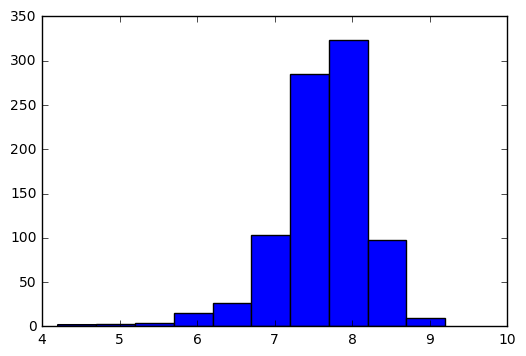

In [368]:
# much better distribution of scores
plt.hist(movies['imdbRating'])
plt.show()

In [369]:
movies.dtypes

Actors           object
Awards           object
Country          object
Director         object
Error            object
Genre            object
Language         object
Metascore        object
Plot             object
Poster           object
Rated            object
Released         object
Response         object
Runtime          object
Title            object
Type             object
Writer           object
Year             object
imdbID           object
imdbRating      float64
imdbVotes        object
totalSeasons     object
dtype: object

In [373]:
movies = movies.drop_duplicates(subset = ['imdbID'])

In [376]:
del movies['Error']
del movies['totalSeasons']

In [378]:
del movies['Poster']

In [383]:
del movies['Metascore']
del movies['Response']

In [385]:
del movies['Released']

In [384]:
movies.to_csv('/Users/teresaborcuch/Desktop/nyt_top1000.csv', encoding = 'utf8')

In [387]:
del movies['Language']

In [408]:
movies['won_Oscar'] = [1 if re.match("Won . Oscar", row[1]) is not None else 0 for i, row in movies.iterrows()]

In [410]:
movies['nominated_Oscar'] = [1 if re.match("Nominated for . Oscar", row[1]) is not None else 0 for i, row in movies.iterrows()]

In [427]:
movies = pd.read_csv('/Users/teresaborcuch/Desktop/nyt_top1000.csv')

In [430]:
movies['Actors'] = movies['Actors'].astype(str)

In [464]:
# do NLP with 2 n-grams on actor field
bigram_vectorizer = CountVectorizer(ngram_range=(2,3), max_features = 1000)
bigram_vectorizer.fit(movies['Actors'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(2, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [465]:
len(bigram_vectorizer.get_feature_names())

1000

In [466]:
bigrams = pd.DataFrame(bigram_vectorizer.transform(movies['Actors']).todense(),
                      columns = bigram_vectorizer.get_feature_names())

In [473]:
# make train and test groups
X_train, X_test, y_train, y_test = train_test_split(bigrams, movies['imdbRating'])

In [467]:
actor_names = bigrams.sum(axis =0)

In [468]:
actor_names.sort_values(ascending = False).head()

burt lancaster     11
cary grant         10
humphrey bogart     9
john wayne          9
dustin hoffman      9
dtype: int64

In [486]:
# fit a Logistic Regression to actor names
y = movies['imdbRating']
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
# use RFECV to pick optimal # of features
rfecv = RFECV(estimator = linreg, cv = 3, scoring = 'mean_squared_error')
rfecv.fit(bigrams, y)

RFECV(cv=3,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   estimator_params=None, scoring='mean_squared_error', step=1, verbose=0)

In [487]:
rfecv_cols = X_train.columns[rfecv.support_]

In [488]:
len(rfecv_cols)

1

In [489]:
rfecv_cols

Index([u'mel gibson'], dtype='object')

In [498]:
mel_x_test = X_test['mel gibson']
mel_x_test = mel_x_test.values.reshape(-1,1)

In [513]:
y_test_re = y_test.values.reshape(-1,1)
print X_train['mel gibson'].shape
print y_train.shape

(646,)
(646,)


In [514]:
linreg = LinearRegression().fit(X_train['mel gibson'].values.reshape(-1,1), y_train)
linreg.score(mel_x_test, y_test_re)

-0.022444488204428126

In [494]:
X_test['mel gibson'].shape

(216,)

In [470]:
model_summary = pd.DataFrame(columns = ['actor','coefficient'])
model_summary['actor'] = bigrams.columns
model_summary['coefficient'] = abs(linreg.coef_)

In [471]:
model_summary.sort_values('coefficient', ascending = False).head(20)

,actor,coefficient
143,de vilallonga,6.318323e+14
317,jessie royce,4.802984e+14
358,josé luis de,4.243735e+14
108,claude brialy,3.536199e+14
15,allen diane,3.395237e+14
0,adolphe menjou,3.137494e+14
142,de sica,2.821537e+14
254,helena bonham carter,2.689854e+14
350,john williams,2.684730e+14
54,benicio del,2.658837e+14
